# FARE Audit Example: Case Study

**Author:** Caitlin Kuhlman
    
Please see our paper:

Caitlin Kuhlman, MaryAnn VanValkenburg, Elke Rundensteiner. "FARE: Diagnostics for Fair Ranking using Pairwise Error Metrics" in the proceedings of the Web Conference (WWW 2019)

In [19]:
import numpy as np
from scipy import stats
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import pandas as pd
import random as random
random.seed(99)
from metrics import *
from audit import *
%matplotlib inline

### Helper Functions

In [43]:
# Simulate systematic unfairness by adding some fixed amount of error "p"

# add noise to both groups to simulate a baseline predictive model
def add_error(data, p, group):
    data2 = data.copy()
    for i in range(len(data)):
        if(data2.iloc[i]['g'] == group):
            data2.iloc[i]['y'] = data2.iloc[i]['y']*(random.uniform(p, 1.1))
        else:
            data2.iloc[i]['y'] = data2.iloc[i]['y']*(random.uniform(0.9, 1.1))
    return data2

# underestimate one group by a factor of "p" to simulate an unfair bias.
def add_error_under(data, p, group):
    data2 = data.copy()
    for i in range(len(data)):
        if(data2.iloc[i]['g'] == group):
            data2.iloc[i]['y'] = data2.iloc[i]['y']*random.uniform(1-p, 1.05)
        else:
            data2.iloc[i]['y'] = data2.iloc[i]['y']*random.uniform(0.95, 1.05)
    #data2.sort_values('y', inplace=True)   
    return data2

# overestimate one group by a factor of "p" to simulate an unfair bias.
def add_error_over(data, p, group):
    data2 = data.copy()
    for i in range(len(data)):
        if(data2.iloc[i]['g'] == group):
            data2.iloc[i]['y'] = data2.iloc[i]['y']*random.uniform(0.9, 1+p)
        else:
            data2.iloc[i]['y'] = data2.iloc[i]['y']*random.uniform(0.95, 1.05)
    #data2.sort_values('y', inplace=True)   
    return data2

# underestimate one group, and overestimate the other by a factor of "p" to simulate an unfair bias.
def add_error_under_over(data, p, group):
    data2 = data.copy()
    for i in range(len(data)):
        if(data2.iloc[i]['g'] == group):
            data2.iloc[i]['y'] = data2.iloc[i]['y']*random.uniform(1-p, 1.05)
        else:
            data2.iloc[i]['y'] = data2.iloc[i]['y']*random.uniform(0.95, 1+p)
    #data2.sort_values('y', inplace=True)   
    return data2

In [68]:
# no legend
def audit_plot(df, title, filename, label=True): 
    
    # Generate diagnostic statistics for the audit
    diag = pd.DataFrame(index=['trend0','trend1','distance'])
    
#     plot
    plt.rcParams['figure.figsize'] = (2.25, 6)
    f, axs = plt.subplots(3, 1, sharex='col', sharey='row')
    e0,e1 = audit_parity(df['y_pred'], df['g'], window=350, step=10)
    diag['parity'] = generate_diagnostics(e0,e1)
    
    axs[0].plot(e0, color='black' ,linewidth=2)
    axs[0].plot(e1, color='red', linestyle='dashed',linewidth=2)
    axs[0].set_yticks([0,0.5,1])
    axs[0].set_yticklabels([0.0,0.5,1.0],fontsize = 14) 
    axs[0].set_title(title, size=24) # Title
                    
    e0,e1 = audit_calibration(df['y'], df['y_pred'], df['g'], window=350, step=10)
    diag['calibration'] = generate_diagnostics(e0,e1)
        
    axs[1].plot(e0, color='black',linewidth=2)
    axs[1].plot(e1, color='red', linestyle='dashed',linewidth=2)
    axs[1].set_yticks([0,0.5,1])
    axs[1].set_yticklabels([0.0,0.5,1.0],fontsize = 14)
        
    e0,e1 = audit_equality(df['y'], df['y_pred'], df['g'], window=350, step=10)
    diag['equality'] = generate_diagnostics(e0,e1)
    
    axs[2].plot(e0, color='black',linewidth=2)
    axs[2].plot(e1, color='red', linestyle='dashed',linewidth=2)
    axs[2].set_yticks([0,0.5,1])
    axs[2].set_yticklabels([0.0,0.5,1.0],fontsize = 14)
    axs[2].xaxis.set_tick_params(labelsize=14)

    if(label):
        axs[0].set_ylabel("Rpar", size=20)
        axs[1].set_ylabel("Rcal", size=20)
        axs[2].set_ylabel("Req", size=20)
        axs[2].set_xlabel("Windows", size=20)
    else:
        axs[0].get_yaxis().set_ticks([])
        axs[1].get_yaxis().set_ticks([])
        axs[2].get_yaxis().set_ticks([])
    
    plt.savefig(filename, bbox_inches='tight')
#     return the diagnostic stats
    return diag


### Generate Random Dataset 

In [44]:
n_points = 1000
n_attr = 5
# random seed for reprodicing experiments
r = 99

X1, y1 = make_regression(n_samples=n_points, n_features=n_attr, noise=0.2, random_state=r)
d1 = np.insert(X1, 5, values=y1, axis=1)
df = pd.DataFrame(d1)
df.columns = ['x0','x1','x2','x3','x4','y']
df = df.sample(frac=1)

# randomly assign evenly sized groups
g1 = np.zeros(int(len(X1)/2))
g2 = np.ones(int(len(X1)/2))
g = np.append(g1, g2)
df['g']=g

#scale y between 0 and 1,sort
df['y'] = (df['y']-df['y'].min()) / (df['y'].max() - df['y'].min())
df.sort_values('y', inplace=True)

# simulate baseline predictions by adding random noise
df['y_pred'] = add_error(df, 0.5, 0.)['y']

df.head()

,x0,x1,x2,x3,x4,y,g,y_pred
341,-1.897510,-1.926044,-1.511468,-2.280682,-0.545986,0.000000,0.0,0.000000
957,-1.093064,-0.590733,-2.509643,-0.140688,-1.877154,0.107379,0.0,0.067545
382,-1.787527,-2.023447,-2.398719,1.825149,-0.885930,0.113730,0.0,0.063679
822,-0.704922,-1.604984,-1.903589,-1.496792,0.008797,0.120433,1.0,0.117341
915,-0.277001,-0.802967,-1.862609,-1.642133,-1.321887,0.127985,1.0,0.124202


### Audit baseline model

In [48]:
# Generate error sequences for the baseline audit
window = 350 
step =10

err0_par, err1_par = audit_parity(df['y_pred'], df['g'], window, step)
err0_eq, err1_eq = audit_equality(df['y'], df['y_pred'], df['g'], window, step)
err0_cal, err1_cal = audit_calibration(df['y'], df['y_pred'], df['g'], window, step)

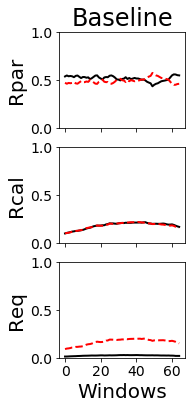

In [50]:
# Create audit plots
plt.rcParams['figure.figsize'] = (2.25, 6)
f, axs = plt.subplots(3, 1, sharex='col', sharey='row')
df['y_pred'] = add_error_under_over(df, 0.1, 0.)['y']

axs[0].plot(err0_par, color='black',linewidth=2)
axs[0].plot(err1_par, color='red', linestyle='dashed',linewidth=2)
axs[0].set_yticks([0,0.5,1]) 
axs[0].set_yticklabels([0.0,0.5,1.0],fontsize = 14)
axs[0].set_title("Baseline", size=24) # Title
    
axs[1].plot(err0_cal, color='black',linewidth=2.0)
axs[1].plot(err1_cal, color='red', linestyle='dashed',linewidth=2.0)
axs[1].set_yticks([0,0.5,1])
axs[1].set_yticklabels([0.0,0.5,1.0],fontsize = 14)
        
axs[2].plot(err0_eq, color='black',linewidth=2)
axs[2].plot(err1_eq, color='red', linestyle='dashed',linewidth=2)
axs[2].set_yticks([0.0,0.5,1])
axs[2].set_yticklabels([0.0,0.5,1.0],fontsize = 14)
axs[2].xaxis.set_tick_params(labelsize=14)

axs[0].set_ylabel("Rpar", size=20)
axs[1].set_ylabel("Rcal", size=20)
axs[2].set_ylabel("Req", size=20)
axs[2].set_xlabel("Windows", size=20)
plt.savefig("charts/base.png", bbox_inches='tight')

In [67]:
# Generate diagnostic statistics for the audit
diag = pd.DataFrame(index=['trend0','trend1','distance'])
diag['parity'] = generate_diagnostics(audit['par'][0], audit['par'][1])
diag['calibration'] = generate_diagnostics(audit['cal'][0], audit['cal'][1])
diag['equality'] = generate_diagnostics(audit['eq'][0], audit['eq'][1])
diag

,parity,calibration,equality
trend0,-0.043661,-0.126297,0.071777
tred1,0.043661,-0.207459,-0.289714
distance,0.164877,0.061481,0.337226


### Simulate different types of error

underestimation 0.5
             parity  calibration  equality
trend0    0.014565    -0.105605  0.016493
trend1   -0.014565    -0.271476 -0.211489
distance  0.193789     0.084802  0.414549
underestimation 0.7
             parity  calibration  equality
trend0   -0.092123    -0.202257  0.013081
trend1    0.092123    -0.428869 -0.331141
distance  0.267703     0.104092  0.466835
overestimation 0.5
             parity  calibration  equality
trend0   -0.092123    -0.202257  0.013081
trend1    0.092123    -0.428869 -0.331141
distance  0.267703     0.104092  0.466835
overestimation 0.7
             parity  calibration  equality
trend0   -0.092123    -0.202257  0.013081
trend1    0.092123    -0.428869 -0.331141
distance  0.267703     0.104092  0.466835
both 0.5
             parity  calibration  equality
trend0   -0.092123    -0.202257  0.013081
trend1    0.092123    -0.428869 -0.331141
distance  0.267703     0.104092  0.466835
both 0.7
             parity  calibration  equality
trend0   -0.0921

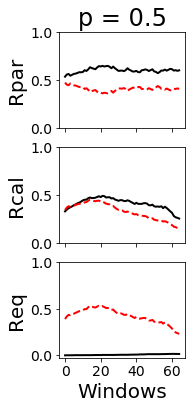

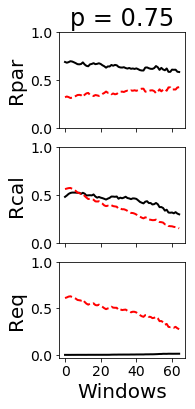

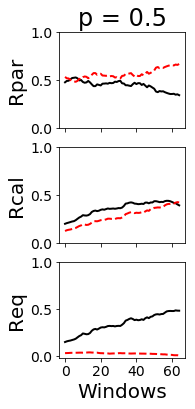

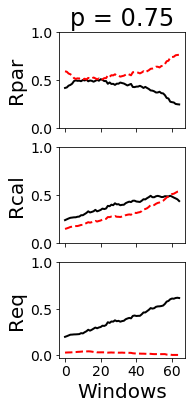

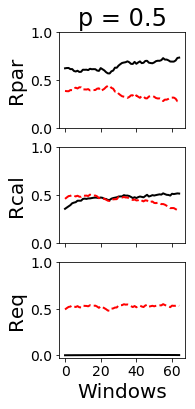

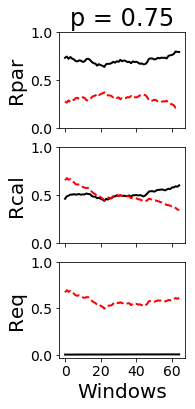

In [73]:
#underestimation
data['y_pred'] = add_error_under(data, 0.5, 0.)['y']
diag = audit_plot(data, "p = 0.5", "charts/under5.png")
print("underestimation 0.5\n", diag)
data['y_pred'] = add_error_under(data, 0.75, 0.)['y']
diag = audit_plot(data, "p = 0.75", "charts/under7.png")
print("underestimation 0.7\n", diag)
# overestimation
data['y_pred'] = add_error_over(data, 0.5, 0.)['y']
audit_plot(data, "p = 0.5", "charts/over5.png")
print("overestimation 0.5\n", diag)
data['y_pred'] = add_error_over(data, 0.75, 0.)['y']
audit_plot(data, "p = 0.75", "charts/over7.png")
print("overestimation 0.7\n", diag)

# both
data['y_pred'] = add_error_under_over(data, 0.5, 0.)['y']
audit_plot(data, "p = 0.5", "charts/both5.png")
print("both 0.5\n", diag)
data['y_pred'] = add_error_under_over(data, 0.75, 0.)['y']
audit_plot(data, "p = 0.75", "charts/both7.png")
print("both 0.7\n", diag)